🔎 Modelo Base:
MAE: 6.96
R²: 0.3948
Acurácia aproximada: 72.16%


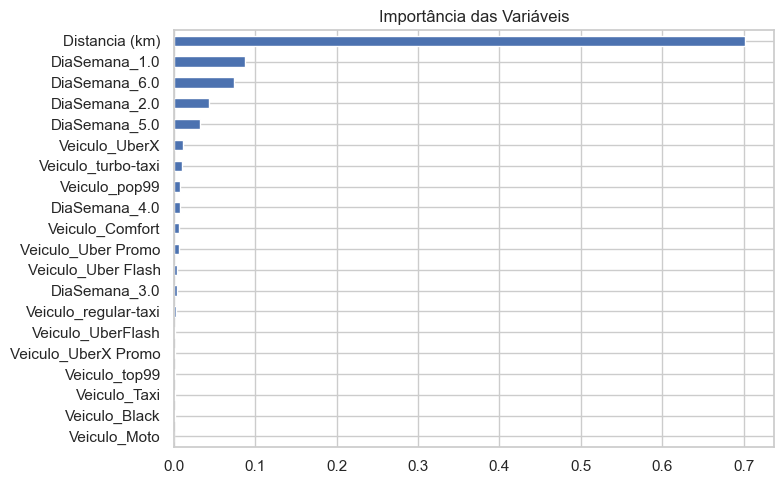


🔧 Após GridSearch:
MAE: 7.09
R²: 0.4261
Acurácia aproximada: 71.65%
Distancia (km)          7.022270e-01
DiaSemana_1.0           8.743268e-02
DiaSemana_6.0           7.351754e-02
DiaSemana_2.0           4.257708e-02
DiaSemana_5.0           3.192954e-02
Veiculo_UberX           1.076923e-02
Veiculo_turbo-taxi      9.741300e-03
Veiculo_pop99           7.103151e-03
DiaSemana_4.0           7.032128e-03
Veiculo_Comfort         6.724956e-03
Veiculo_Uber Promo      5.789566e-03
Veiculo_Uber Flash      3.626133e-03
DiaSemana_3.0           3.266422e-03
Veiculo_regular-taxi    1.999731e-03
Veiculo_UberFlash       1.729560e-03
Veiculo_UberX Promo     1.338805e-03
Veiculo_top99           1.176532e-03
Veiculo_Taxi            1.156580e-03
Veiculo_Black           8.619699e-04
Veiculo_Moto            6.323576e-08
dtype: float64
O preço estimado para 50.0 km, veículo 'Comfort' e dia '1.0' é: R$12.04


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

df = pd.read_csv("resultado_com_dia_semana.csv", sep=";")

df['Distancia (km)'] = df['Distancia (km)'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
df['Price'] = df['Price'].astype(str).str.replace(',', '.', regex=False).astype(float)

df = df[df['Price'] > 0]
df = df[df['Distancia (km)'] > 0]
df = df.dropna()

df = pd.get_dummies(df, columns=['Veiculo', 'DiaSemana'], drop_first=True)

X = df.drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
media_preco = y_test.mean()
acuracia = 1 - (mae / media_preco)

print("🔎 Modelo Base:")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"Acurácia aproximada: {acuracia:.2%}")

importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias.sort_values().plot(kind='barh', title='Importância das Variáveis', figsize=(8,5))
plt.tight_layout()
plt.show()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

melhor_modelo = grid.best_estimator_
y_pred_melhor = melhor_modelo.predict(X_test)
mae_melhor = mean_absolute_error(y_test, y_pred_melhor)
r2_melhor = r2_score(y_test, y_pred_melhor)
acuracia_melhor = 1 - (mae_melhor / media_preco)

print("\n🔧 Após GridSearch:")
print(f"MAE: {mae_melhor:.2f}")
print(f"R²: {r2_melhor:.4f}")
print(f"Acurácia aproximada: {acuracia_melhor:.2%}")
print(importancias.sort_values(ascending=False))

def prever_preco(distancia, tipo_veiculo, dia_semana):
    entrada = pd.DataFrame({
        'Distancia (km)': [distancia],
    })
    
    for veiculo in df.columns:
        if veiculo.startswith('Veiculo_'):
            entrada[veiculo] = 0
    entrada[f'Veiculo_{tipo_veiculo}'] = 1
    
    for dia in df.columns:
        if dia.startswith('DiaSemana_'):
            entrada[dia] = 0
    entrada[f'DiaSemana_{dia_semana}'] = 1

    # Prever o preço com o melhor modelo
    preco_estimado = melhor_modelo.predict(entrada)
    return preco_estimado[0]

distancia_input = 50.0
tipo_veiculo_input = 'Comfort'
dia_semana_input = '1.0' 

preco_estimado = prever_preco(distancia_input, tipo_veiculo_input, dia_semana_input)
print(f"O preço estimado para {distancia_input} km, veículo '{tipo_veiculo_input}' e dia '{dia_semana_input}' é: R${preco_estimado:.2f}")
